In [5]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model



In [7]:

# Define Paths
dataset_dir = "archive/Data"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 5002
Class: Moderate Dementia, Files Found: 488
Class: Non Demented, Files Found: 67222
Class: Very mild Dementia, Files Found: 13725


In [8]:
# Split Dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Total images: {len(image_paths)}")
print(f"Training images: {len(train_paths)}, Testing images: {len(test_paths)}")

Total images: 86437
Training images: 69149, Testing images: 17288


In [ ]:
# Normalize image paths and labels
train_paths = np.array(train_paths)
test_paths = np.array(test_paths)

# One-hot encode the labels
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
test_labels = label_binarizer.transform(test_labels)

# Preprocessing Function for Images
IMG_HEIGHT, IMG_WIDTH = 224, 224

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Load Dataset
def load_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset

# Prepare Train and Test Datasets
train_dataset = load_dataset(train_paths, train_labels)
test_dataset = load_dataset(test_paths, test_labels)

# Batch and Shuffle the Datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2590648089.py, line 16)

In [16]:
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')  # Number of classes
    ])
    return model

model = build_model()
model.summary()

/home/revanth_1206/club/vscode/pyml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
EPOCHS = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,\
    
    epochs=EPOCHS
)

# Save the Model
model.save("alzheimers_detection_model.h5")

Epoch 1/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1317s 609ms/step - accuracy: 0.8359 - loss: 0.4529 - val_accuracy: 0.9843 - val_loss: 0.0441
Epoch 2/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1136s 526ms/step - accuracy: 0.9678 - loss: 0.0840 - val_accuracy: 0.9975 - val_loss: 0.0107
Epoch 3/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 977s 452ms/step - accuracy: 0.9813 - loss: 0.0508 - val_accuracy: 0.9981 - val_loss: 0.0071
Epoch 4/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 970s 449ms/step - accuracy: 0.9861 - loss: 0.0375 - val_accuracy: 0.9976 - val_loss: 0.0069
Epoch 5/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 979s 453ms/step - accuracy: 0.9888 - loss: 0.0308 - val_accuracy: 0.9993 - val_loss: 0.0026
Epoch 6/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 999s 462ms/step - accuracy: 0.9899 - loss: 0.0287 - val_accuracy: 0.9978 - val_loss: 0.0092
Epoch 7/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1429s 661ms/step - accuracy: 0.9894 - loss: 0.0286 - val_accuracy: 0.9998 - val_loss: 0.0017
Epoch 8/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1150s 532ms/step 

541/541 ━━━━━━━━━━━━━━━━━━━━ 81s 150ms/step - accuracy: 0.9994 - loss: 0.0018
Test Loss: 0.0024, Test Accuracy: 0.9992


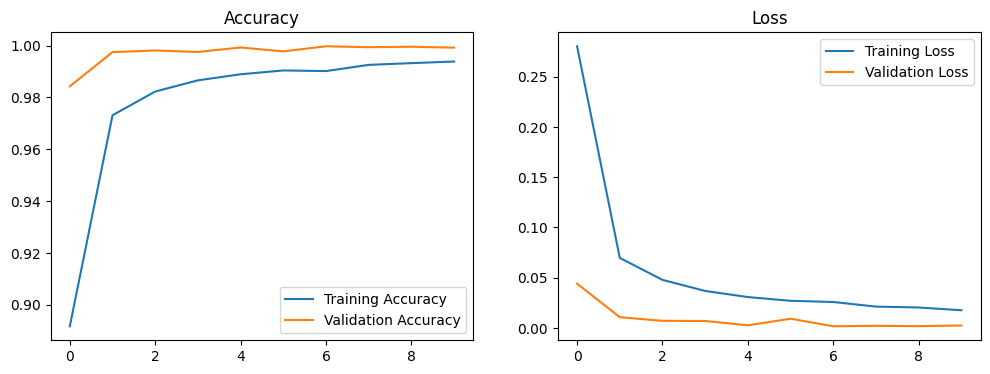

In [18]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

def plot_history(history):
    plt.figure(figsize=(12, 4))
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)

541/541 ━━━━━━━━━━━━━━━━━━━━ 78s 145ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00      1000
 Moderate Dementia       1.00      1.00      1.00        98
      Non Demented       1.00      1.00      1.00     13445
Very mild Dementia       1.00      1.00      1.00      2745

          accuracy                           1.00     17288
         macro avg       1.00      1.00      1.00     17288
      weighted avg       1.00      1.00      1.00     17288



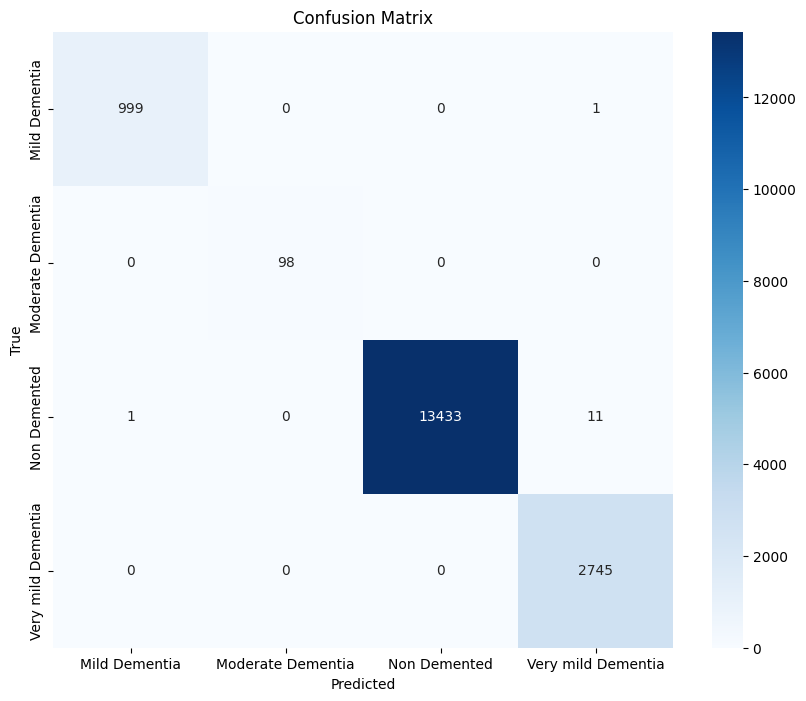

In [ ]:
y_true = np.argmax(test_labels, axis=1)
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)

# Classification Report
class_names = classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Class Index: 2


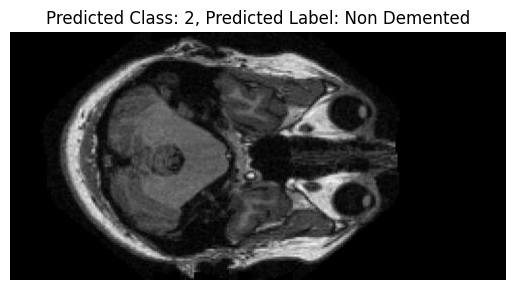

In [37]:
# Preprocess the image
test_image_path = r'dataset_dementia/Data/Non Demented/OAS1_0002_MR1_mpr-3_116.jpg'
test_image = preprocess_image(test_image_path)
test_image = tf.expand_dims(test_image, axis=0)  # Adding batch dimension

# Predict
prediction = model.predict(test_image)
predicted_class = np.argmax(prediction)  # Get the class index
print(f"Predicted Class Index: {predicted_class}")

# Mapping predicted class index to label
class_labels = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very Mild Dementia"]
pred_label = class_labels[predicted_class]

# Display Image + Prediction
plt.imshow(plt.imread(test_image_path))
plt.title(f"Predicted Class: {predicted_class}, Predicted Label: {pred_label}")
plt.axis('off')
plt.show()

In [2]:
import tensorflow as tf
model1 = tf.keras.models.load_model("alzheimers_detection_model.h5")


In [3]:
import numpy as np
from tqdm import tqdm  # For progress bar

def tta_predict(model, dataset, num_augmentations=5):
    predictions = []

    for _ in tqdm(range(num_augmentations), desc="Applying TTA"):
        augmented_predictions = model.predict(dataset)
        predictions.append(augmented_predictions)
    
    # Average the predictions to get more robust results
    averaged_predictions = np.mean(predictions, axis=0)
    return averaged_predictions


In [4]:
# Make predictions using TTA
NUM_AUGMENTATIONS = 5  # You can increase this for better robustness
predictions = tta_predict(model, test_dataset, num_augmentations=NUM_AUGMENTATIONS)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)


NameError: name 'model' is not defined